# Sentiment Analysis using Python

In [ ]:
# Importing the required libraries

import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# Downloading the libraries
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Web Scraping

The web scraping to extract tweets is done through series of steps which invoves:

1) Set up a twitter developer account.

2) Create a project and a standalone app.

3) Save the API keys and access tokens of the account.

4) Download and import the tweepy library

5) Extract the tweets using tweepy library and save it to a file in csv format.

In [ ]:
# The API key of the twitter developer account
API_key = 'IUoGe2RZ0A29MOPy0W4MC4ug4'

# The API secret key of the twitter developer account
API_secret = 'dOHe5Fudq69m9NdCUt6S5kGalONmCjTjBELR6XV0cG6f5W9Te3'

# The access token of the twitter developer account
access_token = '1649054034911965188-hOHTjmiEfRp8SnW4P9AhMsojnO1kMw'

# The access token of the twitter developer account
access_token_secret = '9RlRdzu9oUlzzZUl44bjitX0ZKiSm5h2T4zfVkaCPLBBY'

In [ ]:
# Twitter authentication
auth = tweepy.OAuthHandler(API_key, API_secret)
auth.set_access_token(access_token, access_token_secret)

# Creating an API object
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
hashtags = ['#northwesternuniversity', '#NorthwesternU', '#GoCats', 'NUFBFamily', '#NUAlumni']
num_tweets = 10000

# Collect tweets
all_tweets = []
for hashtag in hashtags:
    # Searching for hastags using Cursor and stroring the hash tags in the tweets
    tweets = tweepy.Cursor(api.search_tweets, q=hashtag, lang='en', tweet_mode='extended').items(num_tweets)
    # Iterating through tweets to skip the retweets and collect the text and metadata from tweets
    for tweet in tweets:
        if hasattr(tweet, 'retweeted_status'):
            # If rewteets, skip to the next tweet
            continue
        tweet_text = tweet.full_text.replace('\n', ' ')
        # Appenind the hastag, text and metadata to the all_tweets list
        all_tweets.append({'Text': tweet_text,
                           'User': tweet.user.screen_name,
                           'Date': tweet.created_at.date(),
                           'Time': tweet.created_at.time()
                           })

In [ ]:
data = pd.DataFrame(all_tweets)

In [ ]:
data.to_csv('/content/tweets_dataset.csv', index=False)

In [ ]:
# Loadind the dataset
df = pd.read_csv('/content/tweets_dataset.csv')

## Preprocessing the data

The data needs to be preprocessed or cleaned such that the data can be useful to train the model. Hence, as we know tweets contains hashtags, mentions and URL and the text needs to cleaned from puntuations, stopwords, hashtags. The next step is to tokenize the text into individual words.

In [ ]:
# Preprocessing the tweets to remove punctuations, stop words, hashtags, mentions from the tweets
def preprocess_text(text):
    # Convert the tweet text to lowercase
    text = text.lower()
    # Removes the URLs from the tweets
    text = re.sub(r'http\S+', '', text)
    # Removes the mentions and hashtags in the tweets
    text = re.sub(r'@\S+|#\S+', '', text)
    # Removes punctuation in the text
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text into individual words
    tokens = word_tokenize(text)
    # Removes stop words from the text
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if not token in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the tokens back into a single string
    text = ' '.join(tokens)
    return text

In [ ]:
# Preprocess the data by calling the preprocess_text function and store the changes back to the dataframe
df['Text'] = df['Text'].apply(preprocess_text)

In [ ]:
# Check for null values in the dataset

df.isnull().sum()

Text    0
User    0
Date    0
Time    0
dtype: int64

There are no null values in the dataset

## Feature extraction

The feature extraction from the data requires the following steps:

1) Create a vocabulary: Create a bag-of-words representation to create a vocabulary of all the unique words in the text.

2) Use TF-IDF: Weigh the importance of each word by using TF-IDF (term frequency-inverse document frequency). This calculates a weight for each word based on how frequently it appears in the text.

In [ ]:
# Labelling the tweets using transformers

# Downloading and importing required libraries
!pip install transformers
import torch
from transformers import pipeline

# Load a pre-trained sentiment analysis model to label the tweets
model = pipeline("sentiment-analysis")

# Define a function to label the sentiment of a tweet
def get_sentiment(text):
    result = model(text)[0]
    label = result['label']
    if label == 'POSITIVE':
        return 1
    elif label == 'NEGATIVE':
        return 0
    else:
        return -1

# Label the sentiment of the tweets in the DataFrame
df['Sentiment'] = df['Text'].apply(get_sentiment)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.3 MB/s eta 0:00:00


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Extract features using bag-of-words approach
vectorizer_bow = CountVectorizer()
features_bow = vectorizer_bow.fit_transform(df['Text'])

# Extract features using TF-IDF approach
vectorizer_tfidf = TfidfVectorizer()
features_tfidf = vectorizer_tfidf.fit_transform(df['Text'])


In [ ]:
df

,Text,User,Date,Time,Sentiment
0,alex grant 24 lhp northwestern university comm...,3leftsbaseball,2023-05-05,02:01:40,1
1,please join u tuesday may 9th 730 ct next medi...,NU_IntMed,2023-05-04,18:56:24,1
2,many congratulation dr peter warnke new,NeurosurgeryUCM,2023-05-03,16:00:38,1
3,fei li kuang md phd awarded grant american aca...,NU_IntMed,2023-05-02,17:01:49,0
4,grant recipient mathers foundation establishin...,NU_IntMed,2023-05-02,16:30:34,1
...,...,...,...,...,...
2345,link nfl 2023,SptsGuy1,2023-05-04,04:47:38,1
2346,personalized nfl kansa city chief 3d baseball ...,peakstuffstyle,2023-05-04,04:46:43,0
2347,personalized nfl la vega raider 3d baseball je...,peakstuffstyle,2023-05-04,04:44:51,0
2348,personalized nfl miami dolphin 3d baseball jer...,peakstuffstyle,2023-05-04,04:42:33,0


## Implementing the sequential neural network model



In [ ]:
# Splitting the dataset such that 80% of dataset is used for training and 20% of dataset is used for testing.

from sklearn.model_selection import train_test_split

# All the features except the target variable is given as input to X
X = df['Text']
# The target variable is given as input to T
y = df['Sentiment']

# Splitting the dataset
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Tokenize the text using white space tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['Text'])

# Pad the sequences to ensure that all sequences have the same length
max_length = max([len(seq) for seq in sequences])

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

### Creating the model

The model is created using embedding layer, LSTM layer, Conv1D, GRU and Dense layers using the tensforflow keras.

In [ ]:
import tensorflow as tf

embedding_size = 50
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size, input_length=max_length),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.GRU(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 46, 50)            297000    
                                                                 
 lstm_2 (LSTM)               (None, 46, 64)            29440     
                                                                 
 conv1d_2 (Conv1D)           (None, 42, 32)            10272     
                                                                 
 gru_2 (GRU)                 (None, 16)                2400      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 339,129
Trainable params: 339,129
Non-trainable params: 0
_________________________________________________________________


### Explanation of code:
This neural network model for text classification using TensorFlow 2 is created. The model architecture consists of an Embedding layer, followed by an LSTM layer with 64 units and a dropout rate of 0.2 for regularization. The LSTM layer is followed by a 1D convolutional layer with 32 filters and a kernel size of 5, which applies filters of size 5 to the sequences outputted by the LSTM. The convolutional layer is followed by a MaxPooling1D layer with pool size 4, which downsamples the output of the convolutional layer by taking the maximum value in each 4-length window. Next, there is a GRU layer with 16 units and ReLU activation. Finally, there is a Dense layer with a single output and sigmoid activation, which outputs the predicted probability of the positive class.

The input to the model is a sequence of integers representing the indices of words in a vocabulary, padded to a fixed length of max_length. The Embedding layer maps each integer to a vector of size embedding_size, which represents the dense vector representation of the corresponding word. The LSTM layer processes the sequence of word vectors and outputs a sequence of hidden states. The convolutional and pooling layers extract features from the output of the LSTM, which are then processed by the GRU layer. The output of the GRU layer is fed to the final Dense layer, which outputs the predicted probability of the positive class.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

### Model training

In [ ]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
59/59 [==============================] - 13s 137ms/step - loss: 0.6762 - accuracy: 0.5941 - val_loss: 0.6733 - val_accuracy: 0.5979
Epoch 2/5
59/59 [==============================] - 7s 115ms/step - loss: 0.6705 - accuracy: 0.6037 - val_loss: 0.6530 - val_accuracy: 0.6766
Epoch 3/5
59/59 [==============================] - 7s 125ms/step - loss: 0.4895 - accuracy: 0.8048 - val_loss: 0.6369 - val_accuracy: 0.6936
Epoch 4/5
59/59 [==============================] - 10s 171ms/step - loss: 0.4063 - accuracy: 0.8362 - val_loss: 0.7605 - val_accuracy: 0.6936
Epoch 5/5
59/59 [==============================] - 9s 149ms/step - loss: 0.1968 - accuracy: 0.9324 - val_loss: 0.7779 - val_accuracy: 0.7277


## Model Evaluation

In [ ]:
# Final evaluation of the model
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9745
Testing Accuracy:  0.7277


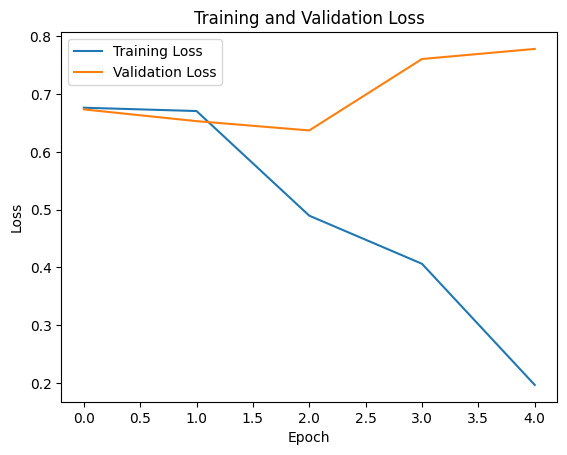

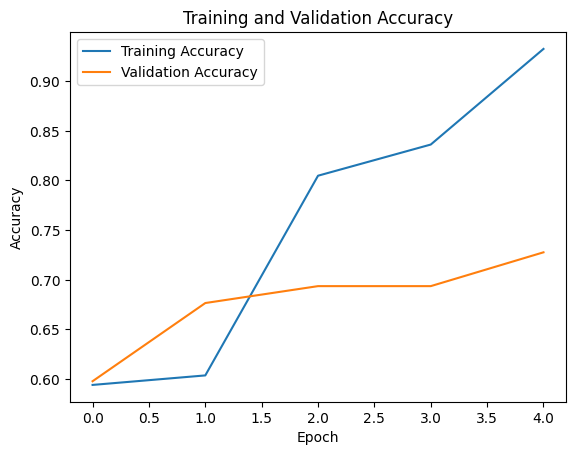

In [ ]:
# Plotting the training and validation loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

15/15 [==============================] - 1s 39ms/step


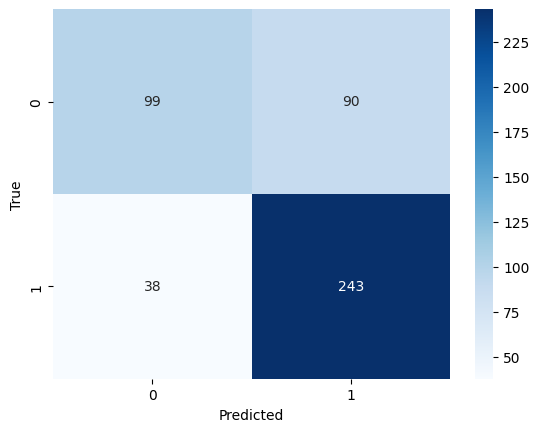

              precision    recall  f1-score   support

           0       0.72      0.52      0.61       189
           1       0.73      0.86      0.79       281

    accuracy                           0.73       470
   macro avg       0.73      0.69      0.70       470
weighted avg       0.73      0.73      0.72       470



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the test data
y_pred = model.predict(X_test)
y_pred = np.array([0 if y<0.55 else 1 for y in y_pred])

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report

print(classification_report(y_test, y_pred))


## Predictions of the model

In [ ]:
# Predicting the sentiment on sample data

y_pred = model.predict(X_test)

for i in range(20):
  if y_pred[i] < 0.5:
    print('NEGATIVE')
  else:
    print('POSITIVE')

15/15 [==============================] - 0s 24ms/step
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
POSITIVE
POSITIVE
POSITIVE
NEGATIVE
NEGATIVE
